In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from autogluon.multimodal import MultiModalPredictor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import math
import shap
import lightgbm as lgb

In [ ]:
stormevents2013 = pd.read_csv("../data/StormEvents_details-ftp_v1.0_d2013_c20250520.csv")

In [88]:
def convert_to_number(x):
    if pd.isna(x):
        return None

    if 'K' in x:
        return float(x.replace('K', '')) * 1000
    elif 'M' in x:
        return float(x.replace('M', '')) * 1000000
    else:
        try:
            return float(x)
        except ValueError:
            return None
    return x


In [128]:
stormevents2013['DAMAGE_PROPERTY_NUM'] = stormevents2013['DAMAGE_PROPERTY'].apply(convert_to_number)
stormevents2013['DAMAGE_CROPS_NUM'] = stormevents2013['DAMAGE_CROPS'].apply(convert_to_number)


In [129]:
#Drop both damages when NA, make 0 when only one is NA
stormevents2013 = stormevents2013.dropna(subset=['DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM'], how='all')
stormevents2013['was_missing_damages'] = stormevents2013[['DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM']].isna().any(axis=1).astype(int)
stormevents2013[['DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM']] = stormevents2013[['DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM']].fillna(0)


In [ ]:
# Add total damages
stormevents2013['total_damages'] = stormevents2013['DAMAGE_PROPERTY_NUM'] + stormevents2013['DAMAGE_CROPS_NUM']

(52259, 55)

In [131]:
#Change be and end date time to dtype datetime and get duration of the event
stormevents2013['BEGIN_DATE_TIME'] = pd.to_datetime(stormevents2013['BEGIN_DATE_TIME'])
stormevents2013['END_DATE_TIME'] = pd.to_datetime(stormevents2013['END_DATE_TIME'])
stormevents2013['event_duration'] = stormevents2013['END_DATE_TIME'] - stormevents2013['BEGIN_DATE_TIME'] 
#Drop time columns but the date_time columns
stormevents2013 = stormevents2013.drop(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'CZ_TIMEZONE', 'END_YEARMONTH', 'END_DAY', 'END_TIME', 'BEGIN_DATE_TIME', 'END_DATE_TIME', 'YEAR', 'MONTH_NAME'], axis = 1)


C:\Users\USER\AppData\Local\Temp\ipykernel_9404\19973914.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stormevents2013['BEGIN_DATE_TIME'] = pd.to_datetime(stormevents2013['BEGIN_DATE_TIME'])
C:\Users\USER\AppData\Local\Temp\ipykernel_9404\19973914.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stormevents2013['END_DATE_TIME'] = pd.to_datetime(stormevents2013['END_DATE_TIME'])


In [166]:
# Convert them to total seconds duration
stormevents2013['event_duration'] = stormevents2013['event_duration'].dt.total_seconds() # convert to seconds

# Confirm conversion
stormevents2013['event_duration'].head()

0    118800.0
1     57600.0
2    151200.0
3         0.0
4     93600.0
Name: event_duration, dtype: float64

In [132]:
#Drop the damages columns (singluar)
stormevents2013 = stormevents2013.drop(['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM'], axis = 1)
#Drop the episode and event id
stormevents2013 = stormevents2013.drop(['EPISODE_ID', 'EVENT_ID'], axis = 1)

In [ ]:
# --- Handle and engineer spatial features ---
for col in ['BEGIN_LAT','BEGIN_LON','END_LAT','END_LON']:
    stormevents2013[col] = pd.to_numeric(stormevents2013[col], errors='coerce')

stormevents2013['END_LAT'] = stormevents2013['END_LAT'].fillna(stormevents2013['BEGIN_LAT'])
stormevents2013['END_LON'] = stormevents2013['END_LON'].fillna(stormevents2013['BEGIN_LON'])

def haversine(lat1, lon1, lat2, lon2):
    
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0

    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0

    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) + pow(math.sin(dLon / 2), 2) * math.cos(lat1) * math.cos(lat2))
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    return rad * c


stormevents2013['EVENT_LENGTH_KM'] = stormevents2013.apply(lambda row: haversine(row['BEGIN_LAT'], row['BEGIN_LON'], row['END_LAT'], row['END_LON']), axis=1)

stormevents2013 = stormevents2013.drop(columns=['BEGIN_LAT','BEGIN_LON','END_LAT','END_LON'], errors='ignore')

In [ ]:
#from geopy.distance import geodesic

#stormevents2013['distance_km'] = stormevents2013.apply(
#    lambda row: geodesic((row.BEGIN_LAT, row.BEGIN_LON), (row.END_LAT, row.END_LON)).km, axis=1
#)

In [2]:
#stormevents2013.to_csv('../data/stormevents2013_cleaned.csv', index=False)
stormevents2013 = pd.read_csv("../data/stormevents2013_cleaned.csv")

In [4]:
train_stormevents2013, test_stormevents2013 = train_test_split(stormevents2013,
                                                    random_state=42, 
                                                    test_size = 1/3,
                                                    shuffle=True)

In [15]:
print(train_stormevents2013.shape)

print(test_stormevents2013.shape)
stormevents2013.head()

(34839, 36)
(17420, 36)


,STATE,STATE_FIPS,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,...,END_RANGE,END_AZIMUTH,END_LOCATION,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,was_missing_damages,total_damages,event_duration,EVENT_LENGTH_KM
0,NEW HAMPSHIRE,33,Winter Weather,Z,12,EASTERN HILLSBOROUGH,BOX,0,0,0,...,NaN,NaN,NaN,A coastal low moved southeast of southern New ...,Three to five inches of snow fell across easte...,CSV,0,0.0,118800.0,NaN
1,NEW HAMPSHIRE,33,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,0,0,0,...,NaN,NaN,NaN,"Low pressure moved out of the midwest, off the...",Eight to nine inches of snow fell across easte...,CSV,0,0.0,57600.0,NaN
2,NEW HAMPSHIRE,33,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,0,0,0,...,NaN,NaN,NaN,This storm brought heavy snow and significant ...,Five to sixteen inches of snow fell across eas...,CSV,0,0.0,151200.0,NaN
3,NEW HAMPSHIRE,33,Strong Wind,Z,12,EASTERN HILLSBOROUGH,BOX,0,0,0,...,NaN,NaN,NaN,A warm front moved northward across southern N...,A tree on Harbor Avenue was downed.,CSV,0,3000.0,0.0,NaN
4,NEW HAMPSHIRE,33,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,0,0,0,...,NaN,NaN,NaN,An historic winter storm deposited tremendous ...,Sixteen to twenty-four inches of snow fell acr...,CSV,0,0.0,93600.0,NaN


In [ ]:
#Autogluon (about 23 mins) TabularPredictor
predictor = TabularPredictor(label='total_damages', path='../models/Autogluon_models').fit(train_data=train_stormevents2013, time_limit=3600)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       0.99 GB / 7.89 GB (12.5%)
Disk Space Avail:   821.05 GB / 931.51 GB (88.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='hig

In [ ]:
#Autogluon MultiModalPredictor
predictor_multimodal = MultiModalPredictor(label='total_damages', path='../models/Autogluon_models_multimodal').fit(train_data=train_stormevents2013, time_limit=300)

=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Pytorch Version:    2.7.1+cpu
CUDA Version:       CUDA is not available
GPU Count:          0
Memory Avail:       0.48 GB / 7.89 GB (6.0%)
Disk Space Avail:   820.75 GB / 931.51 GB (88.1%)
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (297250000.0, 0.0, 183152.85025, 3389294.69096)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you ha

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

In [3]:
predictor = TabularPredictor.load('../models/Autogluon_models/')
#score_val = -metric_value
predictor.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-2.533200e+06,root_mean_squared_error,0.087768,151.102085,0.000000,0.019976,2,True,10
1,NeuralNetFastAI,-2.533200e+06,root_mean_squared_error,0.087768,151.082108,0.087768,151.082108,1,True,6
2,RandomForestMSE,-4.036874e+06,root_mean_squared_error,0.071861,394.293922,0.071861,394.293922,1,True,3
3,ExtraTreesMSE,-4.235089e+06,root_mean_squared_error,0.131380,581.840932,0.131380,581.840932,1,True,5
4,LightGBMLarge,-4.246216e+06,root_mean_squared_error,0.092751,19.574712,0.092751,19.574712,1,True,9
5,LightGBM,-4.522623e+06,root_mean_squared_error,0.025929,4.165881,0.025929,4.165881,1,True,2
6,XGBoost,-4.544057e+06,root_mean_squared_error,0.087763,14.368630,0.087763,14.368630,1,True,7
7,CatBoost,-4.547157e+06,root_mean_squared_error,0.103762,62.181993,0.103762,62.181993,1,True,4
8,LightGBMXT,-4.613698e+06,root_mean_squared_error,0.045878,3.516608,0.045878,3.516608,1,True,1
9,NeuralNetTorch,-4.928661e+06,root_mean_squared_error,0.074800,52.420010,0.074800,52.420010,1,True,8


In [ ]:
#Importance about 9 mins
importance = predictor.feature_importance(test_stormevents2013)

In [5]:
#importance.to_csv('../models/Autogluon_models/feature_importance.csv', index=True)
importance = pd.read_csv('../models/Autogluon_models/feature_importance.csv', index_col=0)

In [9]:
importance.head(50)

,importance,stddev,p_value,n,p99_high,p99_low
DEATHS_DIRECT,1.779287e+06,1.209929e+06,0.015132,5,4.270548e+06,-7.119749e+05
INJURIES_DIRECT,9.048839e+05,1.081569e+06,0.067354,5,3.131849e+06,-1.322081e+06
END_LOCATION,8.129290e+05,1.452376e+06,0.139460,5,3.803391e+06,-2.177533e+06
TOR_LENGTH,7.815807e+05,7.428555e+05,0.039145,5,2.311130e+06,-7.479691e+05
CZ_NAME,6.231169e+05,5.405298e+05,0.030738,5,1.736075e+06,-4.898413e+05
SOURCE,6.037619e+05,5.881860e+05,0.041685,5,1.814845e+06,-6.073212e+05
TOR_OTHER_CZ_STATE,5.163227e+05,9.165213e+05,0.138135,5,2.403453e+06,-1.370807e+06
TOR_OTHER_WFO,5.158112e+05,9.176754e+05,0.138596,5,2.405317e+06,-1.373695e+06
TOR_OTHER_CZ_NAME,5.155709e+05,9.176796e+05,0.138693,5,2.405086e+06,-1.373944e+06
WFO,3.191615e+05,3.227430e+05,0.045749,5,9.836938e+05,-3.453708e+05


In [29]:
# Choose the LightGBM model
lgb_model = predictor._trainer.load_model('LightGBM')

# Access the underlying LightGBM Booster
booster = lgb_model.model

In [ ]:
#predictor._trainer.load_model('WeightedEnsemble_L2')

In [11]:
X_train = train_stormevents2013.drop(columns=['total_damages'])
y_train = train_stormevents2013['total_damages']
X_test = test_stormevents2013.drop(columns=['total_damages'])
y_test = test_stormevents2013['total_damages']

In [12]:
#AutoGluon’s internal feature generator (turns raw → numeric).
X_test_internal = predictor.transform_features(X_test)

In [14]:
X_test_internal.head()

,STATE_FIPS,CZ_TYPE,CZ_FIPS,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,MAGNITUDE,TOR_LENGTH,TOR_WIDTH,...,__nlp__.wind damage,__nlp__.wind gust,__nlp__.wind gusts,__nlp__.winds,__nlp__.winds and,__nlp__.winter,__nlp__.with,__nlp__.with the,__nlp__.within,__nlp__._total_
12757,17,1,87,0,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,35
15226,6,1,53,0,0,0,0,61.0,NaN,NaN,...,0,0,2,2,0,0,0,0,0,31
26361,39,0,11,0,0,0,0,55.0,NaN,NaN,...,0,0,0,2,1,0,0,0,0,65
19140,35,1,510,0,0,0,0,NaN,NaN,NaN,...,0,0,0,2,0,0,2,1,0,68
39079,30,1,10,0,0,0,0,51.0,NaN,NaN,...,0,0,1,2,0,0,1,0,0,44


In [67]:
X_test_internal['EPISODE_NARRATIVE'].head(10)
X_test_internal['CZ_NAME'].head(10)

12757     757
15226    2185
26361      76
19140    1794
39079     622
10533    1145
32456     274
42336     839
49953     362
4421      236
Name: CZ_NAME, dtype: category
Categories (2393, int64): [0, 1, 2, 3, ..., 2389, 2390, 2391, 2392]

C:\Users\USER\AppData\Local\Temp\ipykernel_16844\3907955586.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_internal)


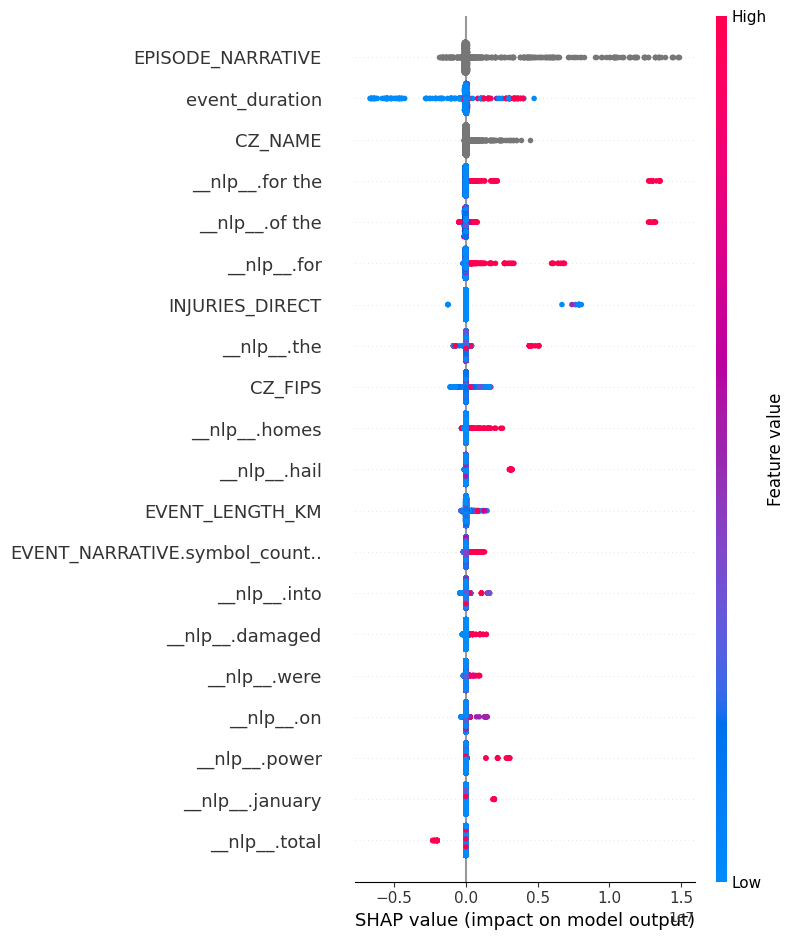

In [ ]:
# Run SHAP using the transformed features
explainer = shap.TreeExplainer(lgb_model.model)
shap_values = explainer.shap_values(X_test_internal)

#SHAP plot, only the top most influential features globally (by mean absolute SHAP value) are shown
#Grey dots mean they are categorical values and not numerical
#Red dots mean they have high numerical value in the data frame, blue vise versa
shap.summary_plot(shap_values, X_test_internal)

In [ ]:
#pd.crosstab(stormevents2013['DAMAGE_PROPERTY_NUM'].isna(), stormevents2013['DAMAGE_CROPS_NUM'].isna())
#stormevents2013['DAMAGE_CROPS_NUM'].isna()
#plt.hist(stormevents2013['DAMAGE_CROPS_NUM'], bins = 10)
#stormevents2013[['BEGIN_DATE_TIME', 'BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME']].head()

,BEGIN_DATE_TIME,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME
0,23-FEB-13 19:00:00,201302,23,1900
1,14-DEC-13 21:00:00,201312,14,2100
2,07-MAR-13 15:00:00,201303,7,1500
3,07-OCT-13 18:30:00,201310,7,1830
4,08-FEB-13 15:00:00,201302,8,1500
